# AD Classification Notebook

In this notebook we load the **Group 6 model**, which was fine-tuned on the ADReSS dataset.  
The model weights can be downloaded here: [weights](https://technionmail-my.sharepoint.com/my?id=%2Fpersonal%2Fyarden%5Fnahum%5Fcampus%5Ftechnion%5Fac%5Fil%2FDocuments%2F%D7%A4%D7%A8%D7%95%D7%99%D7%A7%D7%98%20%D7%AA%D7%9B%D7%9F&viewid=80aca3e3%2Dbd79%2D43a9%2D91ca%2D05ae2b1505ec)

After loading the model, we use it to classify the synthetic stories we generated for different personas.  
At the end, a **DataFrame** is displayed, showing for each persona the model’s probability estimates (healthy vs. AD) together with its confidence.  

Currently, the stories from **06/07** look more consistent and suitable for the model.

In [1]:
import json
from pathlib import Path
from typing import List, Dict, Union, Optional
import torch
import pandas as pd
from transformers import AutoTokenizer
from transformers import AutoTokenizer, AutoModel
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class ADClassifier(nn.Module):
    def __init__(self, model_name: str, dropout=0.1, hidden_dim=None):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        h = self.bert.config.hidden_size
        h2 = hidden_dim or (h // 2)
        self.drop = nn.Dropout(dropout)
        self.fc1  = nn.Linear(h, h2)
        self.bn   = nn.BatchNorm1d(h2)
        self.act  = nn.ReLU()
        self.fc2  = nn.Sequential(
            nn.Linear(h2, h2//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2//2, 2)
        )

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = out.pooler_output
        x = self.drop(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.drop(x)
        return self.fc2(x)

In [3]:
# -------- CONFIG --------
MODEL_NAME = "bert-base-uncased"
CKPT_PATH  = "best_model_base_bert.pt"
MAX_LEN    = 512         # max tokens 
BATCH_SIZE = 16
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- LOAD MODEL + TOKENIZER --------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = ADClassifier(model_name=MODEL_NAME, dropout=0.1).to(DEVICE)
state = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

ADClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [4]:
@torch.no_grad()
def predict_proba(texts: List[str]) -> torch.Tensor:
    """Return class probabilities [N, 2]: [:,0]=Control, [:,1]=AD."""
    all_probs = []
    for i in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[i:i+BATCH_SIZE]
        enc = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,               # dynamic padding
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        logits = model(enc["input_ids"], enc["attention_mask"])  # [B, 2]
        probs = torch.softmax(logits, dim=-1).cpu()
        all_probs.append(probs)
    return torch.cat(all_probs, dim=0) if all_probs else torch.empty(0, 2)

def compute_predicted_start_age(ages: List[int], prob_ad: List[float], threshold: float = 0.5) -> Optional[int]:
    """
    Optional helper:
    Return the first age where prob_ad >= threshold (default 0.5).
    If never crosses threshold, return None.
    """
    if not ages:
        return None
    # Ensure ages and prob_ad are aligned and sorted by age
    paired = sorted(zip(ages, prob_ad), key=lambda x: x[0])
    for age, p in paired:
        if p >= threshold:
            return age
    return None

In [5]:
def df_from_person_json(person: Dict, add_predicted_start_age: bool = False, threshold: float = 0.5) -> pd.DataFrame:
    """
    Build a DataFrame for a single person JSON with 'start_deterioration_age' column preserved.
    """
    name = person.get("name", "UNKNOWN")
    sda  = person.get("start_deterioration_age", None)  # <-- keep provided start age
    stories = person.get("stories", [])

    texts = [s.get("story", "") for s in stories]
    ages  = [s.get("age", None) for s in stories]

    probs = predict_proba(texts)  # [N,2]
    if probs.numel() == 0:
        cols = ["person_name","start_deterioration_age","age","story","prob_control","prob_ad","pred_label","confidence"]
        return pd.DataFrame(columns=cols)

    prob_control = probs[:, 0].numpy()
    prob_ad      = probs[:, 1].numpy()
    pred_label   = probs.argmax(dim=1).numpy()
    confidence   = probs.max(dim=1).values.numpy()

    df = pd.DataFrame({
        "person_name": name,
        "start_deterioration_age": sda,            # <-- column per row
        "age": ages,
        "story": texts,
        "prob_control": prob_control,
        "prob_ad": prob_ad,
        "pred_label": pred_label,                  # 0=Control, 1=AD
        "confidence": confidence
    }).sort_values("age", kind="stable").reset_index(drop=True)

    if add_predicted_start_age:
        predicted = compute_predicted_start_age(df["age"].tolist(), df["prob_ad"].tolist(), threshold=threshold)
        df["predicted_start_age"] = predicted  # same value for all rows of this person
        df.attrs["predicted_start_age_threshold"] = threshold  # store threshold as metadata (optional)

    return df

In [6]:
def run_on_json_file(json_path: Union[str, Path], add_predicted_start_age: bool = False, threshold: float = 0.5) -> pd.DataFrame:
    with open(json_path, "r", encoding="utf-8") as f:
        person = json.load(f)
    return df_from_person_json(person, add_predicted_start_age=add_predicted_start_age, threshold=threshold)

def run_on_json_dir(json_dir: Union[str, Path], add_predicted_start_age: bool = False, threshold: float = 0.5) -> pd.DataFrame:
    json_dir = Path(json_dir)
    dfs = []
    for p in sorted(json_dir.glob("*.json")):
        try:
            df = run_on_json_file(p, add_predicted_start_age=add_predicted_start_age, threshold=threshold)
            df["source_file"] = p.name
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] Failed on {p}: {e}")
    if not dfs:
        cols = ["person_name","start_deterioration_age","age","story","prob_control","prob_ad","pred_label","confidence","source_file"]
        if add_predicted_start_age:
            cols.append("predicted_start_age")
        return pd.DataFrame(columns=cols)
    return pd.concat(dfs, ignore_index=True)

# Usage

In [7]:
df_one = run_on_json_file("/Users/yardennahum/AD project/AD_LongitudinalDataGenerator/stories/data_06_07/alison.json", add_predicted_start_age=True, threshold=0.5)
df_one

,person_name,start_deterioration_age,age,story,prob_control,prob_ad,pred_label,confidence,predicted_start_age
0,alison,66,60,I remember the day Farida came into the librar...,0.898948,0.101052,0,0.898948,69
1,alison,66,63,Farida. I think about her more than I let on. ...,0.814136,0.185864,0,0.814136,69
2,alison,66,66,"There was this woman, Farida... she came in wi...",0.857289,0.142711,0,0.857289,69
3,alison,66,69,"A woman—her name... Farina? No, that’s not rig...",0.377394,0.622606,1,0.622606,69
4,alison,66,75,There was someone... a woman who came to the.....,0.672050,0.327950,0,0.672050,69


## Prediction on old stories (using ChatGPT UI - 6/7 data) 

Processing EVA.json...
Processing Jacob.json...
Processing Mike_Donovan.json...
Processing alison.json...
Processing thomas.json...


,person_name,start_deterioration_age,age,story,prob_control,prob_ad,pred_label,confidence,predicted_start_age,source_file
0,Eva Sanderson,66,60,"It was the final week of the semester, and we ...",0.846906,0.153094,0,0.846906,69,EVA.json
1,Eva Sanderson,66,63,"A few years back—three, maybe—we were deep int...",0.709398,0.290602,0,0.709398,69,EVA.json
2,Eva Sanderson,66,66,"We were reading Morrison—yes, 'Beloved'—and I’...",0.894320,0.105681,0,0.894320,69,EVA.json
3,Eva Sanderson,66,69,There was this day—must’ve been a while ago—we...,0.324361,0.675639,1,0.675639,69,EVA.json
4,Eva Sanderson,66,75,"There was... a boy. He said something, once. A...",0.429900,0.570100,1,0.570100,69,EVA.json
5,Jacob Stein,72,60,"It was 1993, my first time speaking at the Int...",0.920830,0.079169,0,0.920830,None,Jacob.json
6,Jacob Stein,72,63,"I gave this lecture back in ’93, in Geneva—on ...",0.655936,0.344064,0,0.655936,None,Jacob.json
7,Jacob Stein,72,66,"The Geneva talk—yes, that one was... 1993? I t...",0.924446,0.075554,0,0.924446,None,Jacob.json
8,Jacob Stein,72,69,I think it was Geneva—maybe ’92 or ’93. I was ...,0.668905,0.331095,0,0.668905,None,Jacob.json
9,Jacob Stein,72,75,"There was a... a place, across the ocean. I sp...",0.681613,0.318387,0,0.681613,None,Jacob.json


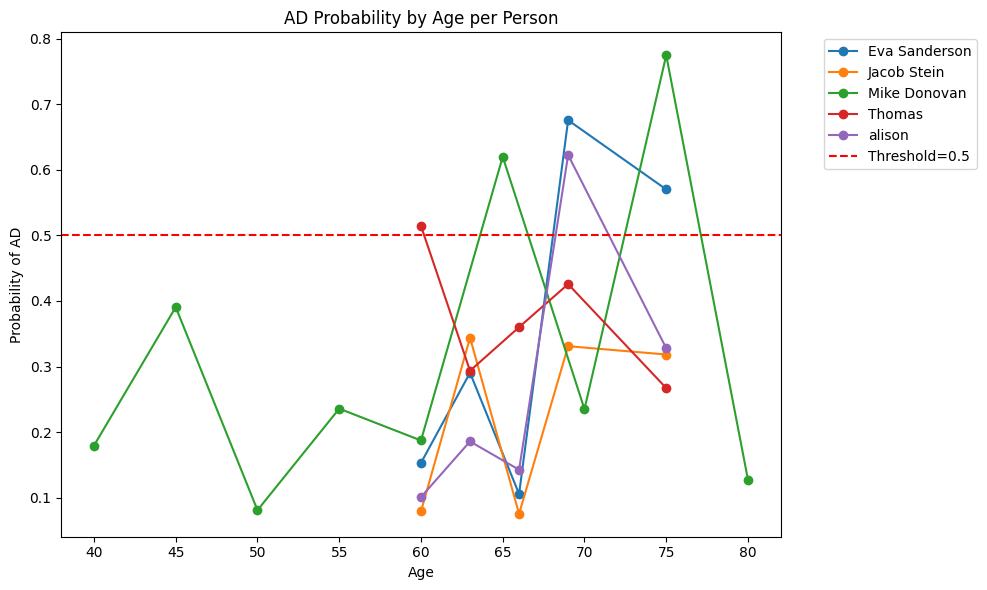

In [ ]:
# Path to your folder with persona JSONs
data_dir = Path("/Users/yardennahum/AD project/AD_LongitudinalDataGenerator/stories/data_06_07/")

dfs = []

# Iterate over all .json files in the folder
for json_file in sorted(data_dir.glob("*.json")):
    print(f"Processing {json_file.name}...")

    # Load JSON
    with open(json_file, "r", encoding="utf-8") as f:
        person = json.load(f)

    # Run predictions and build DataFrame
    df = df_from_person_json(person, add_predicted_start_age=True, threshold=0.5)
    df["source_file"] = json_file.name  # keep track of source file

    dfs.append(df)

# Concatenate all results into one DataFrame
df_all = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame
display(df_all)

# --- Informative Plot ---
# Plot prob_ad vs. age for each person
plt.figure(figsize=(10,6))
for person_name, subdf in df_all.groupby("person_name"):
    plt.plot(subdf["age"], subdf["prob_ad"], marker="o", label=person_name)

plt.axhline(0.5, color="red", linestyle="--", label="Threshold=0.5")
plt.xlabel("Age")
plt.ylabel("Probability of AD")
plt.title("AD Probability by Age per Person")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Prediction on new stories (using Copilot - 10/8 data)

Processing Anthony Samuel Reyes.json...
Processing George Leonard.json...
Processing Jacob Stein.json...
Processing James Whitaker.json...
Processing Jessica Marie Holloway.json...
Processing Keren Aliza Hadar.json...
Processing Lisa Carmen Alvarez.json...
Processing Mark Edward Thompson.json...
Processing Olivia Margaret Chen.json...
Processing Robert Elias Garner.json...


,person_name,start_deterioration_age,age,story,prob_control,prob_ad,pred_label,confidence,predicted_start_age,source_file
0,Anthony Samuel Reyes,72,60,"It was that blue hour before sunrise, the city...",0.951423,0.048577,0,0.951423,None,Anthony Samuel Reyes.json
1,Anthony Samuel Reyes,72,63,Same thin hour before the city turns loud. I r...,0.913326,0.086674,0,0.913326,None,Anthony Samuel Reyes.json
2,Anthony Samuel Reyes,72,66,"That early slice before sun, when the avenues ...",0.930652,0.069348,0,0.930652,None,Anthony Samuel Reyes.json
3,Anthony Samuel Reyes,72,69,Pre‑dawn quiet again. Blue gray streets. I get...,0.943954,0.056046,0,0.943954,None,Anthony Samuel Reyes.json
4,Anthony Samuel Reyes,72,72,It is that soft... that soft blue time. I have...,0.915144,0.084856,0,0.915144,None,Anthony Samuel Reyes.json
5,Anthony Samuel Reyes,72,75,Blue early. The ride again. Girl. Young woman....,0.946303,0.053697,0,0.946303,None,Anthony Samuel Reyes.json
6,George Leonard,75,60,"It was a late autumn evening, clinic lights lo...",0.968069,0.031930,0,0.968069,None,George Leonard.json
7,George Leonard,75,63,Evening clinic hush. I was finishing records w...,0.964986,0.035014,0,0.964986,None,George Leonard.json
8,George Leonard,75,66,Autumn night again in my mind: lights half dim...,0.965273,0.034727,0,0.965273,None,George Leonard.json
9,George Leonard,75,69,"Late day hush, door knock, older couple, golde...",0.964931,0.035069,0,0.964931,None,George Leonard.json


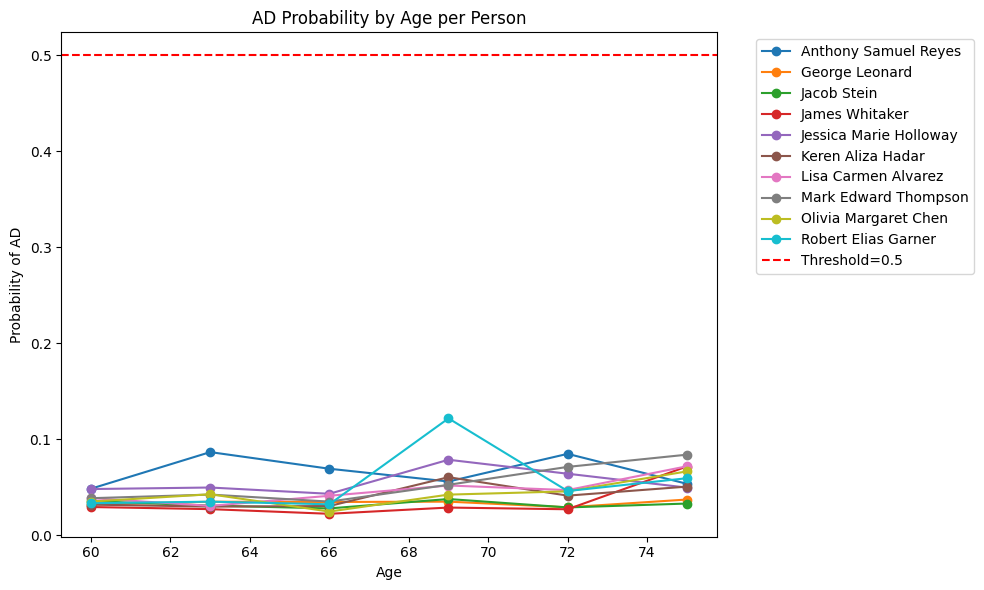

In [10]:
# Path to your folder with persona JSONs
data_dir = Path("/Users/yardennahum/AD project/AD_LongitudinalDataGenerator/stories/data_aug_10/dementia/")

dfs = []

# Iterate over all .json files in the folder
for json_file in sorted(data_dir.glob("*.json")):
    print(f"Processing {json_file.name}...")

    # Load JSON
    with open(json_file, "r", encoding="utf-8") as f:
        person = json.load(f)

    # Run predictions and build DataFrame
    df = df_from_person_json(person, add_predicted_start_age=True, threshold=0.5)
    df["source_file"] = json_file.name  # keep track of source file

    dfs.append(df)

# Concatenate all results into one DataFrame
df_all = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame
display(df_all)

# --- Informative Plot ---
# Plot prob_ad vs. age for each person
plt.figure(figsize=(10,6))
for person_name, subdf in df_all.groupby("person_name"):
    plt.plot(subdf["age"], subdf["prob_ad"], marker="o", label=person_name)

plt.axhline(0.5, color="red", linestyle="--", label="Threshold=0.5")
plt.xlabel("Age")
plt.ylabel("Probability of AD")
plt.title("AD Probability by Age per Person")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()